# **Applying DRL for FIR Filter Implementation - Stage 1 - Section 2** 

## Scope - *Analayzing the FIR Filters generated by Direct Truncation of Fourier Series*
References:- the section 9.3 of the book, *Digital Signal Processing, signals systems and filters*, by *Andreas Antoniou*

In [42]:
import os, sys
import time
import numpy as np
from scipy.io import wavfile
from scipy.fft import fft, rfft, fftshift, fftfreq
from scipy.signal import convolve, freqz
import matplotlib.pyplot as plt

sys.path.insert(1, '../')
from helper import Spectrum, power

### Loading the Audio Files

In [3]:
# Let's first load the audio files
log_path = "audio_files/"
src_audio_name = 'vignesh'
target_audio_file = src_audio_name + '-target-MONO.wav'
jammed_audio_file = src_audio_name + '-jammed-MONO.wav'

if not os.path.exists(log_path+target_audio_file):
    raise Exception(f"the target audio signal, {log_path+target_audio_file}, doesn't exist.")
sampling_rate, target_signal = wavfile.read(log_path+target_audio_file)

if not os.path.exists(log_path+jammed_audio_file):
    raise Exception(f"the jammed audio signal, {log_path+jammed_audio_file}, doesn't exist.")
sampling_rate_, jammed_signal = wavfile.read(log_path+jammed_audio_file)

if sampling_rate != sampling_rate_:
    Exception(f"the two sampling rates are not equal, {sampling_rate} and {sampling_rate_}")
print(f"audio files have been successfully loaded: target - {log_path+target_audio_file}, jammed - {log_path+jammed_audio_file}")
print(f"sampling rate: {sampling_rate}Hz")


audio files have been successfully loaded: target - audio_files/vignesh-target-MONO.wav, jammed - audio_files/vignesh-jammed-MONO.wav
sampling rate: 44100Hz


In [125]:
# verify
_, original_signal = wavfile.read(log_path+'vignesh.wav')
# for i in range(100):
#     print(original_signal[i], target_signal[i], jammed_signal[i])
print(original_signal.dtype, target_signal.dtype, jammed_signal.dtype)

int16 int32 int32


Text(0, 0.5, 'magnitude')

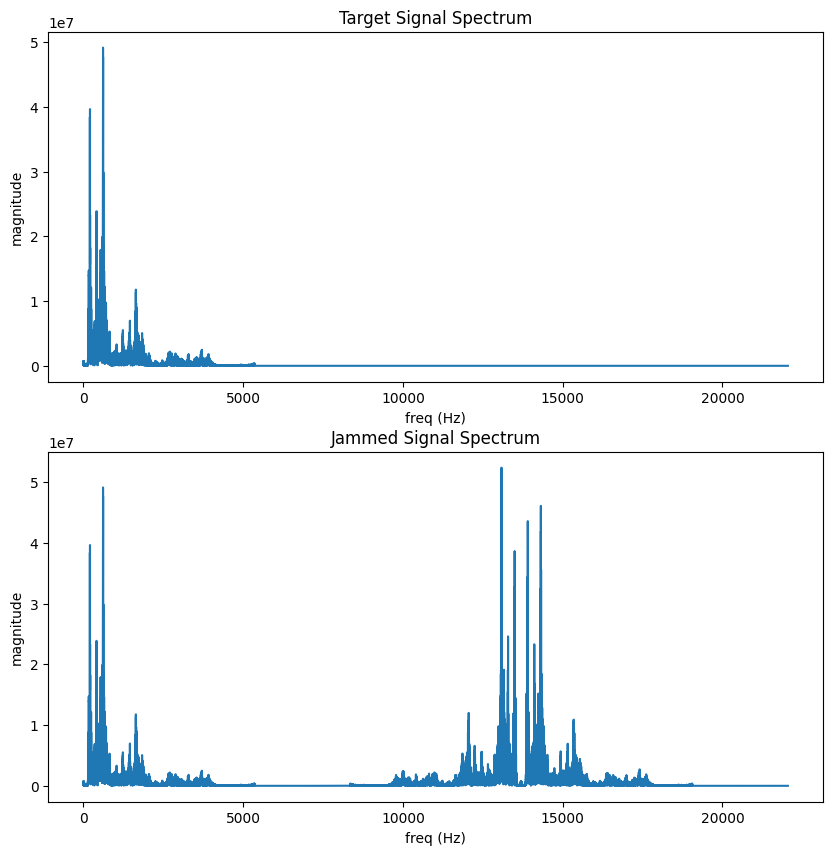

In [126]:
# visulaizing the spectrums 

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(*Spectrum(target_signal, 1/sampling_rate))
axs[0].set_title("Target Signal Spectrum")
axs[0].set_xlabel("freq (Hz)")
axs[0].set_ylabel("magnitude")
axs[1].plot(*Spectrum(jammed_signal, 1/sampling_rate))
axs[1].set_title("Jammed Signal Spectrum")
axs[1].set_xlabel("freq (Hz)")
axs[1].set_ylabel("magnitude")

### Implementing the Filters

- An ideal Low Pass Filter (LPF) with a cut-off frequnency $\omega_c$ has a passband with a unity gain and a stopband with zero gain, as represented by the formula;
$H(e^{j \omega t}) = \left \{ 
    \begin{array}{rcl}
        1 & for & |\omega| \leqslant \omega_c \\
        0 & for & \omega_c < |\omega| \leqslant \omega_s/2\\
    \end{array}\right.$. Here, $\omega_s$ is the sampling frequency of the signals.
- To achieve the above ideal frequency response, the impulse response of the filter, $h[n]$, must be symmetric and infinite in length and is given by the equation; 
$h[n] = 1/n\pi \sin (\omega_c n T)$.

In [4]:
# helper functions for STAGE-2

def LPF(N: int, cut_off_freq: int|float, sampling_freq: int|float = 1):
    """
    Implements a Low Pass Filter with the specified cut-off frequency and the filter length using the method of direct truncation of Fourier Series. 
    (refer to the section 9.3 of the book 'Digital Signal Processing, signals systems and filters')

    :param N: filter length; must be an odd integer; if an even integer is assigned, an error will be raised. 
    :param cut_off_freq: cut-off frequency of the filter; must be in the same units as 'sampling_freq'.
    :paramm sampling_freq: sampling frequency of the signal; defaults to 1. 
    """

    if N%2==0:
        # if N is even, raise an error
        raise Exception("the filter length must be odd.")
    
    n = np.arange(-(N-1)/2, (N-1)/2+1)
    filter = 2*cut_off_freq/sampling_freq * np.sinc(2*cut_off_freq/sampling_freq * n)

    return n, filter

def apply_filter(filter, signal):
    """
    Applies the given filter on the provided signal and returns the filtered signal.
    Filtered signal would have the same length as the input signal; make sure that the provided signal is larger than the filter. 

    :param filter: an array containing the coefficients of the FIR filter
    :param signal: an array corresponding to the signal sequence 
    """

    return convolve(signal, filter, mode='same')

def mean_L1_dist(sig1, sig2):
    """
    Returns the L1 distance (Manhattan distance) of the two signals provided: sig1 and sig2.
    The two signals must of the same length; if not, a broadcasting error will be raised. 

    :param sig1: a numpy array representing the first signal
    :param sig2: a numpy array representing the second signal 
    """
    return np.sum(np.abs(sig1 - sig2)) / len(sig1)

def mean_L2_dist(sig1, sig2):
    """
    Returns the L2 distance (Euclidean) of the two signals provided: sig1 and sig2.
    The two signals must of the same length; if not, a broadcasting error will be raised. 

    :param sig1: a numpy array representing the first signal
    :param sig2: a numpy array representing the second signal 
    """
    return np.sqrt(np.sum((sig1 - sig2)**2) / len(sig1)) # RMS

def mean_Lp_dist(sig1, sig2, p: int):
    """
    Returns the Lp distance of the two signals provided: sig1 and sig2.
    The two signals must of the same length; if not, a broadcasting error will be raised. 

    :param sig1: a numpy array representing the first signal
    :param sig2: a numpy array representing the second signal 
    """
    return (np.sum(np.abs(sig1 - sig2)**p) / len(sig1))**(1/p)


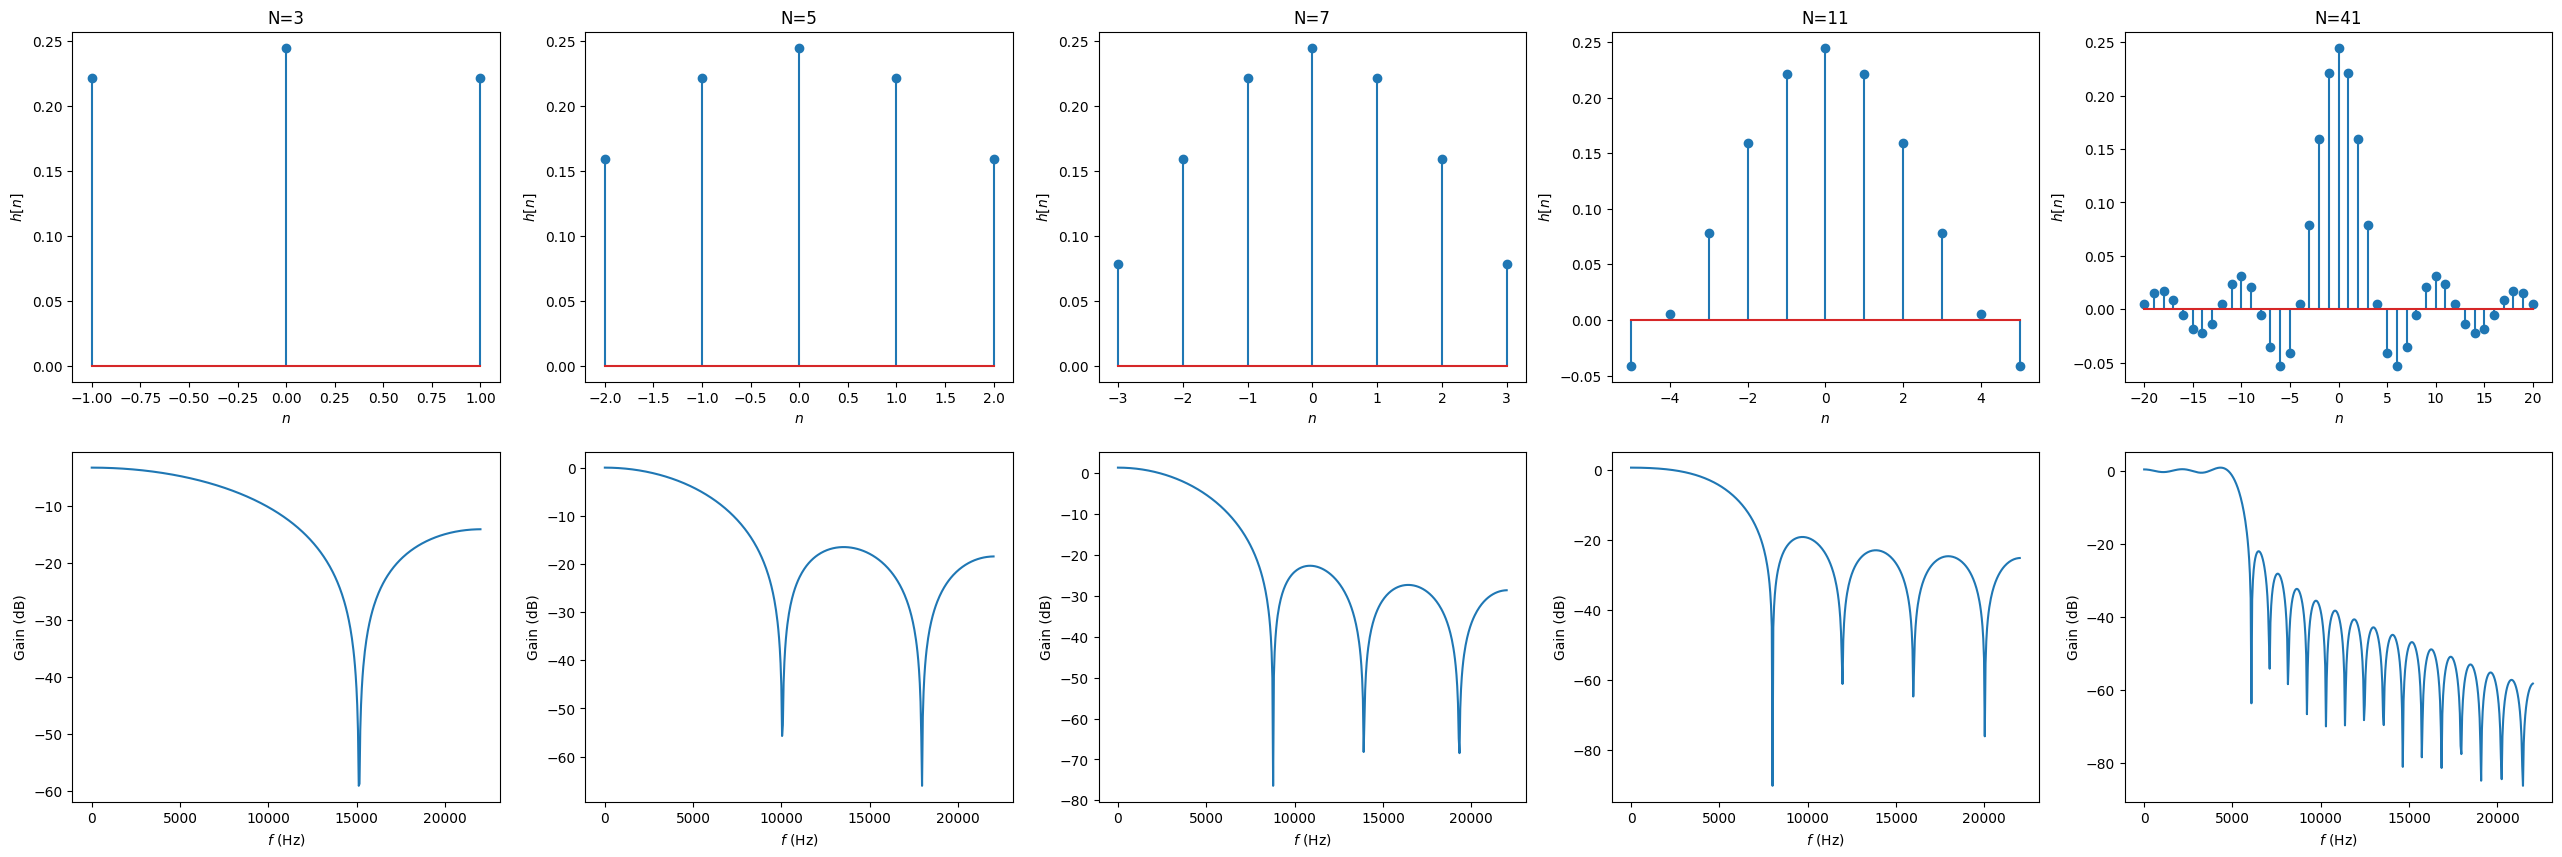

In [4]:
# analyzing filters with different lengths and their frequency responses 

# sampling_rate = 44_100
cut_off_freq = 5400 # Hz

fig, axs = plt.subplots(2, 5, figsize=(32, 10))
for i, N in enumerate([3, 5, 7, 11, 41]):
    n, filter = LPF(N, cut_off_freq, sampling_rate)
    axs[0][i].stem(n, filter)
    axs[0][i].set_title(f"N={N}")
    axs[0][i].set_xlabel("$n$")
    axs[0][i].set_ylabel("$h[n]$")

    # plotting the frequency response of the filter
    w, h = freqz(filter, fs=sampling_rate)
    axs[1][i].plot(w, 20*np.log10(np.abs(h)))
    axs[1][i].set_xlabel("$f$ (Hz)")
    axs[1][i].set_ylabel("Gain (dB)")


### Applying Filters to the Selected Jammed Audio Signal

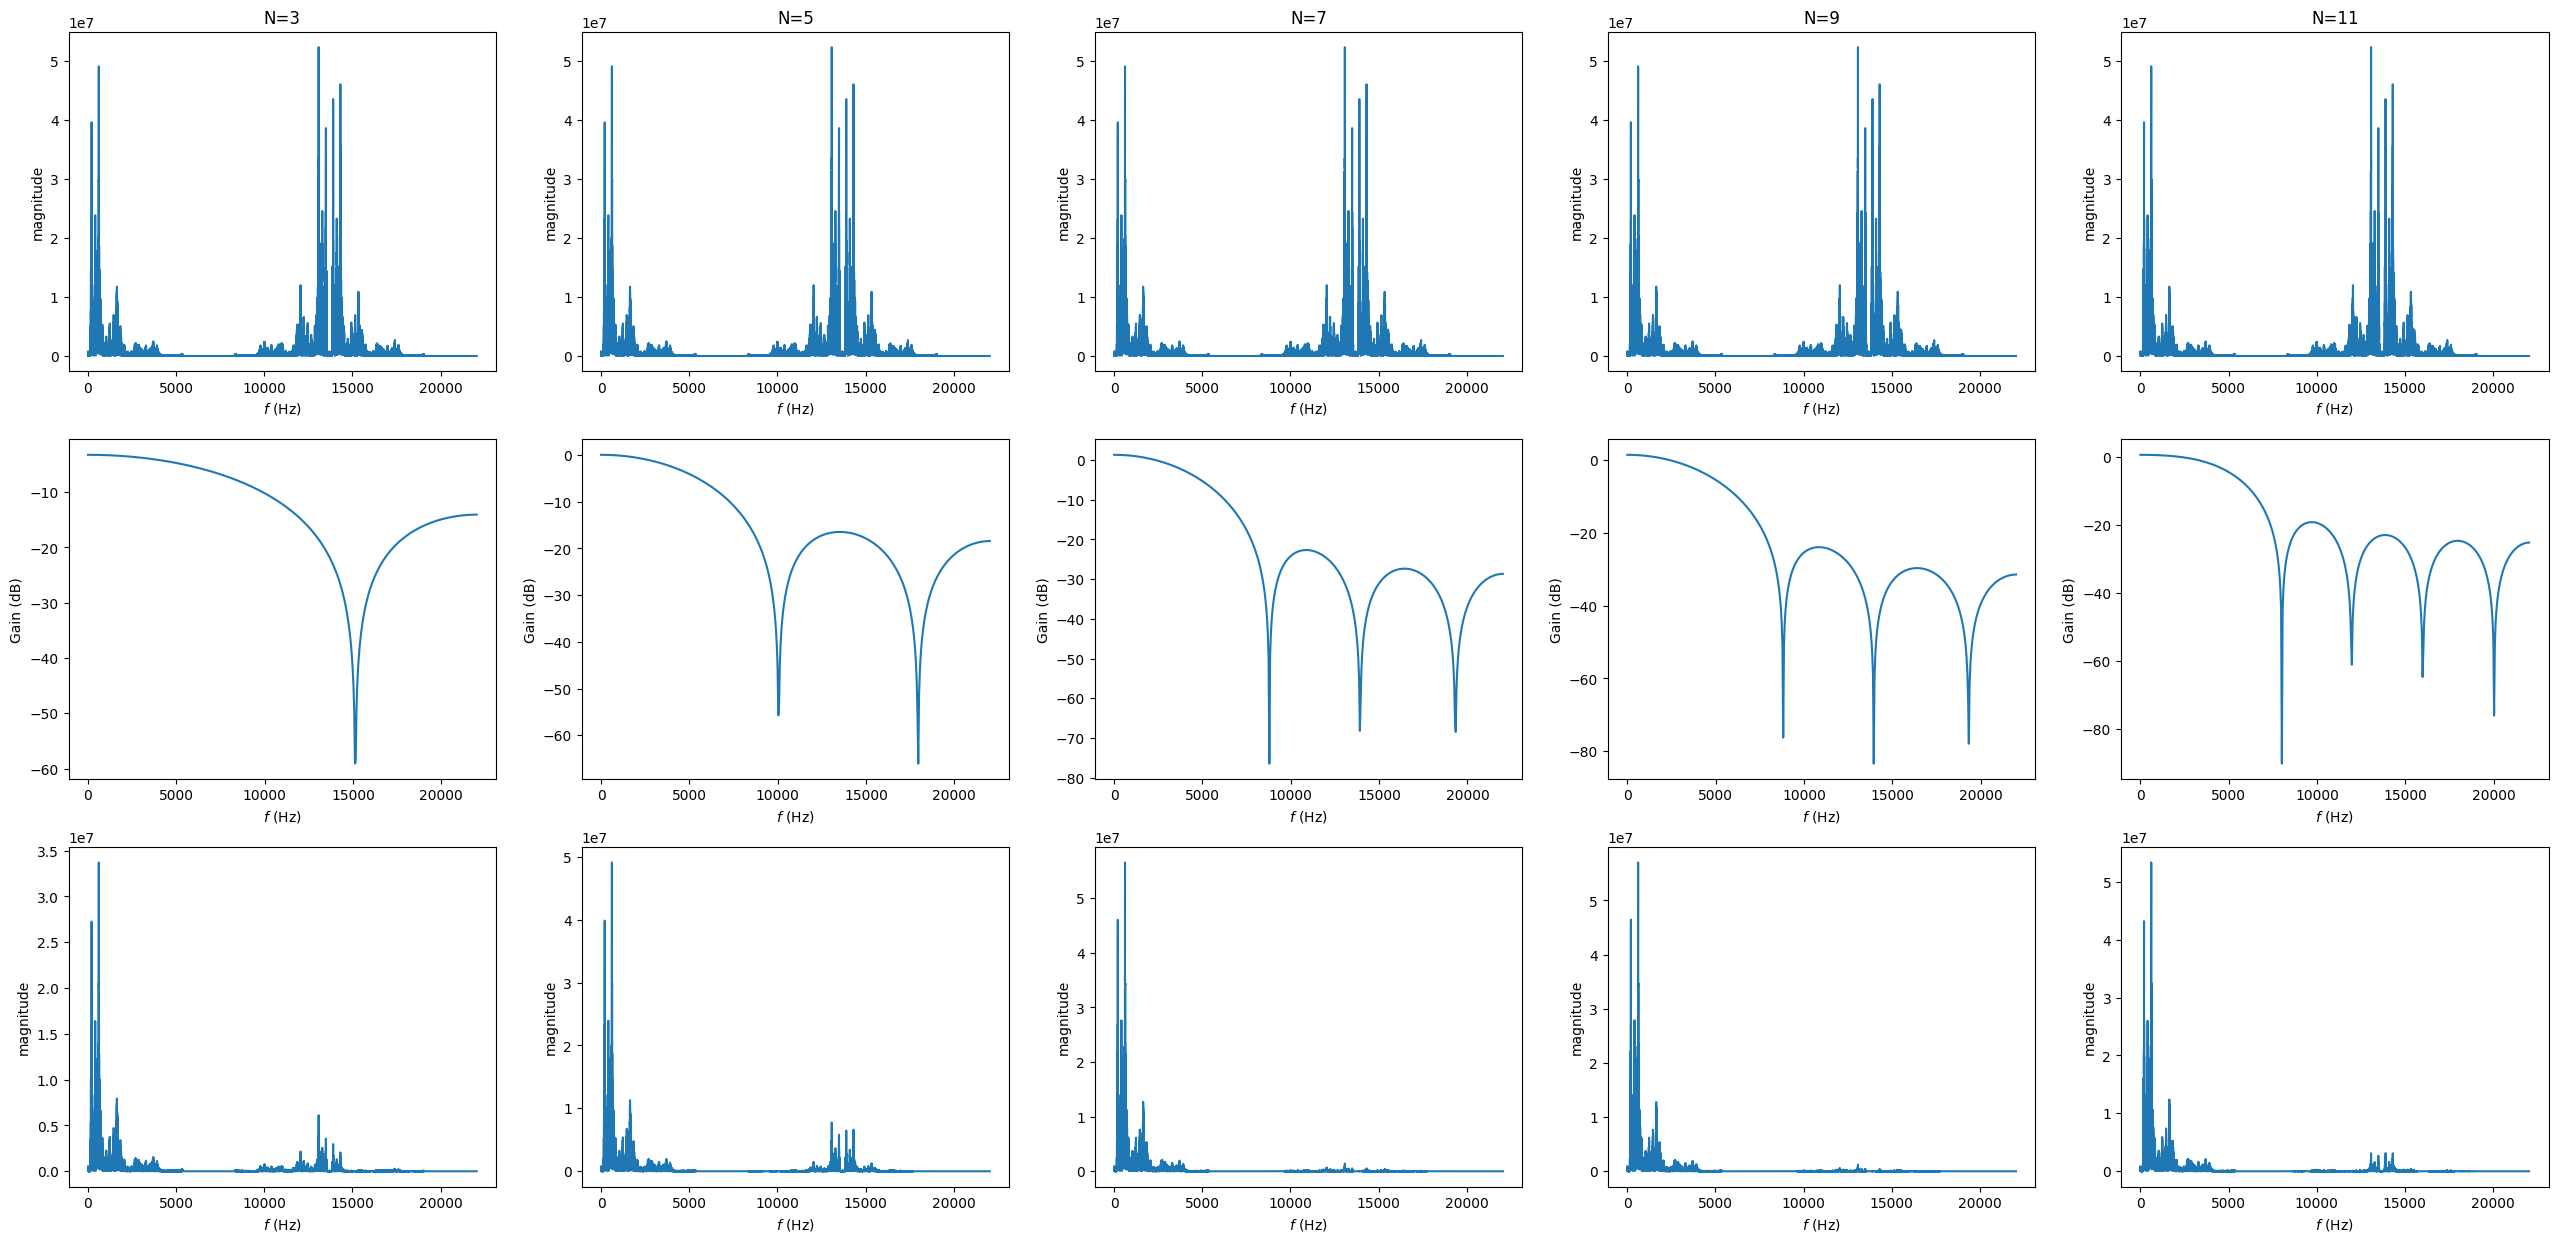

In [129]:
# peform filtering 
fig, axs = plt.subplots(3, 5, figsize=(32, 15))

for i, N in enumerate([3, 5, 7, 9, 11]):
    n, filter = LPF(N, cut_off_freq, sampling_rate)
    filtered_signal = apply_filter(filter, jammed_signal)
    Spectrum(filtered_signal, sampling_space=1/sampling_rate)

    # plotting the signal frequency spectrums before filtering
    axs[0][i].set_title(f"N={N}")
    axs[0][i].plot(*Spectrum(jammed_signal, sampling_space=1/sampling_rate))
    axs[0][i].set_xlabel("$f$ (Hz)")
    axs[0][i].set_ylabel("magnitude")

    # plotting the frequency response of the filter
    w, h = freqz(filter, fs=sampling_rate)
    axs[1][i].plot(w, 20*np.log10(np.abs(h)))
    axs[1][i].set_xlabel("$f$ (Hz)")
    axs[1][i].set_ylabel("Gain (dB)")

    # plotting the frequency spectrums after filtering
    axs[2][i].plot(*Spectrum(filtered_signal, sampling_space=1/sampling_rate))
    axs[2][i].set_xlabel("$f$ (Hz)")
    axs[2][i].set_ylabel("magnitude")


### Evaluating the Filters 
- Evaluation of the performance of a filter can be done by estimating the distance/differene between the target output and the filtered output signals. 
- Since all audio signals are simply 1-D sequences, they can be interpreted as vectors; then, intiutively, to estimate the difference between two signals, $L^p$ vector distances can be used. 
- For simplicity, we will mainly focus on the most common $L^1$ (Manhattan distance) and $L^2$ (Eucledian distance) distances in this case. 
- However, the difference or the error value obtained by this method grows with the signal sequence length; therefore, to have a performance metric independent of the processed signals, we will take the mean $L^p$ distance between individiual time samples of target and filtered signals (this is equivalent to an RMS (root mean square) error when $L^2$ norms are considered).
- Comming up with an appropriate and a reliable performance metric for the filter peformance is vital because this notion of better filters will be later exploited to derive the rewards in the RL process.

**Update** - (*from 18/10/2023 meeting*)
- To evaluate the filter performance, a better metric to use is the **Signal-to-Noise ratio (SNR)** of the filter output. 
- An ideal reward signal in the MDP modeling of the adaptive RL filter must be ultimately based on the BER of the filter output because number of bit errros (BER) in the output signal is what we target to reduce using our adaptive filter. 
- Since there exists a direct inverse relationship between SNR and BER, we can incorporate BER through SNR without having to perform sample-to-bit conversion required to estimate BER directly from the output signal. 
- As shown in *notebook-stage_1.1*, above mentioned sample-to-bit conversion adds a significant overhead to the computation time and must be omitted at all cost. 
- Also notice that, the $L^p$ norms we used earlier are not correctly normalized to the filter input and hence cannot be accepted as an effective reward signal determinant. 

##### $L^p$ Distance vs Filter Length

average sample value of the target signal: 2569.8045517160526


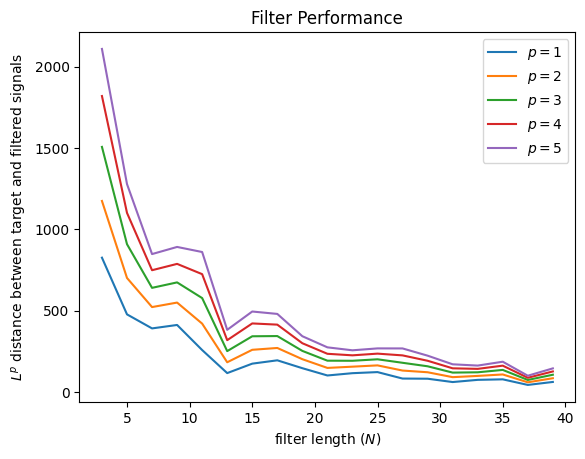

In [130]:
# evaluating the filering process 
print(f"average sample value of the target signal: {np.mean(np.abs(target_signal))}")
Lp_distances = np.zeros((5, len(range(3, 41, 2))))
for i, N in enumerate(range(3, 41, 2)):
    _, filter = LPF(N, cut_off_freq=5400, sampling_freq=sampling_rate)
    filtered_signal = apply_filter(filter, jammed_signal)
    Lp_distances[:, i] = [mean_Lp_dist(target_signal, filtered_signal, p=order) for order in range(1, 5+1)]

plt.plot(range(3, 41, 2), Lp_distances.T, label=["$p=1$", "$p=2$", "$p=3$", "$p=4$", "$p=5$"])
plt.title("Filter Performance")
plt.xlabel("filter length ($N$)")
plt.ylabel("$L^p$ distance between target and filtered signals")
plt.legend()

##### SNR as Reward Signal

SNR is calculataed as $SNR = 10 \log (P_{signal}/P_{noise})$, where $P_{signal} = \sum_{i=1}^{L} (x[i])^2$ is the target signal (SoI) power and $P_{noise} = \sum_{i=1}^{L} (n[i])^2$ is the noise signal power. The noise signal is given by $n[i] = y[i] - x[i]$, where $y[i]$ is the filter output signal. ($L$ is the length of the signals considered.)

In [38]:
def SNR(X, Y):
    """
    Estimates the SNR in dB of a filter output signal Y taking X as the SoI; SNR = 20 log (power(Y-X) / power(X))
    :param X: SoI (Signal of Interest)
    :param Y: filter output (SoI + noise)
    """

    return 10 * np.log10(power(X)/power(Y-X))

seperation between two sub-sequences: 13647 (<class 'numpy.uint32'>)
[[ 4.30550000e+04  1.99386247e+03  1.33432839e+01]
 [-4.83690000e+04  1.03937815e+08             nan]
 [ 4.56362000e+05  3.88704432e+07 -1.93031002e+01]
 [-2.22569000e+05  2.33200331e+07             nan]
 [-2.61942000e+05  2.97231616e+07             nan]
 [-8.91300000e+04  7.14620005e+07             nan]
 [ 2.06415000e+05  1.64606716e+07 -1.90170630e+01]
 [ 1.61668000e+05  1.14856974e+07 -1.85153331e+01]
 [ 1.87880000e+05  1.71093891e+07 -1.95935395e+01]
 [-1.19978000e+05  5.94181259e+07             nan]]


/tmp/ipykernel_9588/2528043852.py:8: RuntimeWarning: invalid value encountered in log10
  return 10 * np.log10(power(X)/power(Y-X))


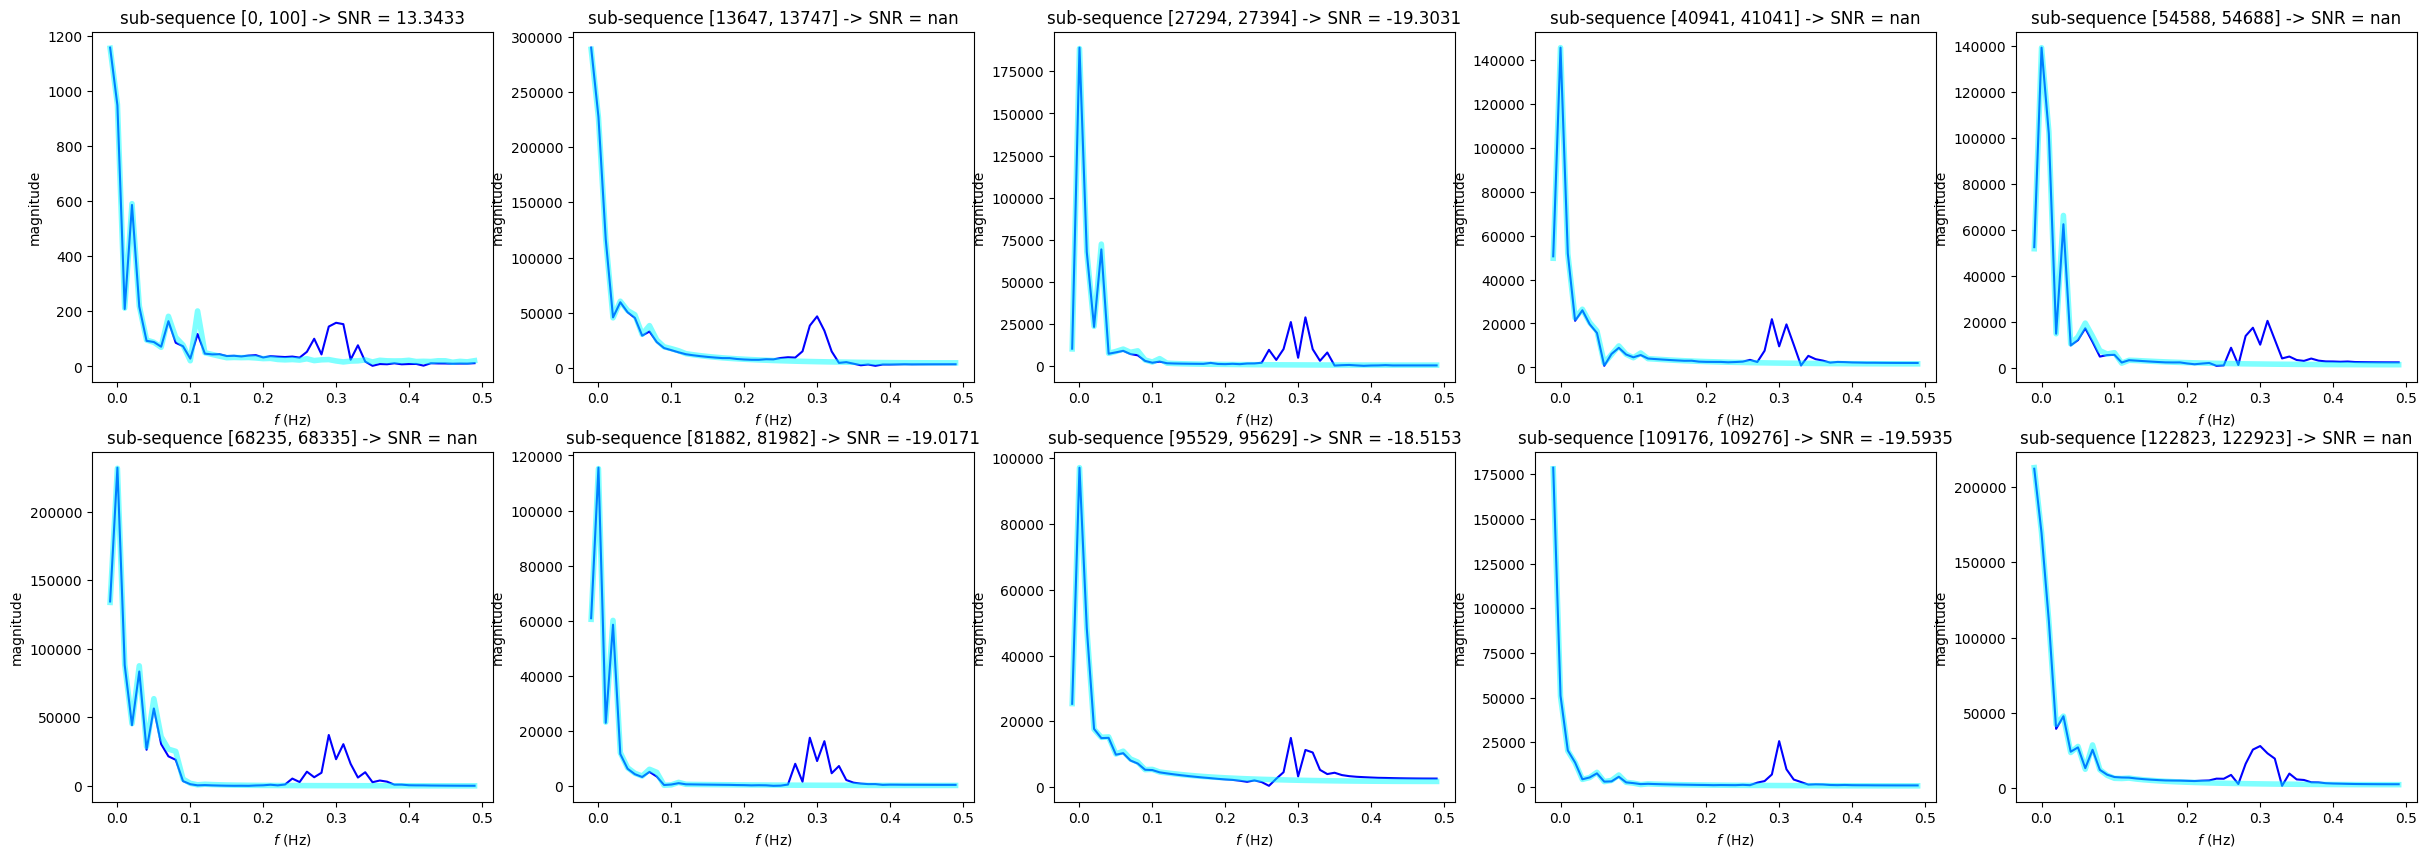

In [39]:
# visualizing SNR 

SNR_buffer = np.zeros((10, 3))

cut_off_freq = 5400 # Hz
_, filter = LPF(5, cut_off_freq, sampling_rate)
filtered_signal = apply_filter(filter, jammed_signal)

# jammed_signal = np.concatenate((np.zeros(1000), jammed_signal))
fig, axs = plt.subplots(2, 5, figsize=(30,10))

N = 100 # the size/length of a sub-sequence
S = np.floor(len(jammed_signal)/10).astype(np.uint32) # seperation size between sub-sequences, we take 10 N-long sub-sequences of S apart
print(f"seperation between two sub-sequences: {S} ({type(S)})")
if S < N:
    raise Exception(f"the provided signal is not long enough for the following code")
for i in range(10):
    Y = filtered_signal[S*i : S*i + N]
    X = target_signal[S*i : S*i + N]
    SNR_value = SNR(X, Y)
    SNR_buffer[i][0] = power(X)
    SNR_buffer[i][1] = power(Y-X)
    SNR_buffer[i][2] = SNR_value

    axs[i//5, i%5].plot(*Spectrum(Y), color='blue')
    axs[i//5, i%5].plot(*Spectrum(X), alpha=0.5, color='cyan', linewidth=4)
    axs[i//5, i%5].set_title(f"sub-sequence [{S*i}, {S*i + N}] -> SNR = {np.round(SNR_value, 4)}")
    axs[i//5, i%5].set_xlabel("$f$ (Hz)")
    axs[i//5, i%5].set_ylabel("magnitude")

print(SNR_buffer)

In [16]:
# analysis
for i in range(10):
    print(SNR_buffer[i][0], SNR_buffer[i][1], SNR_buffer[i][2])

43055.0 1993.8624718813282 13.343283943371237
-48369.0 103937815.3953442 nan
456362.0 38870443.21063913 -19.303100178423925
-222569.0 23320033.113591213 nan
-261942.0 29723161.59040139 nan
-89130.0 71462000.47526039 nan
206415.0 16460671.627060665 -19.01706297380567
161668.0 11485697.44000382 -18.515333060906407
187880.0 17109389.10006381 -19.593539515887578
-119978.0 59418125.86240648 nan


In [43]:
Y = filtered_signal[S*i : S*i + N]
X = target_signal[S*i : S*i + N]

print(X)
np.sum(np.abs(X.astype(np.int32)) ** 2)
power(X)

[ 2395  1488   537  -427 -1371 -2249 -3011 -3608 -3999 -4166 -4119 -3904
 -3597 -3290 -3067 -2990 -3080 -3318 -3660 -4049 -4437 -4795 -5118 -5416
 -5709 -6015 -6340 -6684 -7036 -7381 -7696 -7959 -8139 -8207 -8139 -7919
 -7550 -7052 -6461 -5820 -5167 -4527 -3907 -3297 -2674 -2018 -1314  -566
   204   956  1638  2195  2580  2765  2748  2556  2243  1880  1540  1282
  1143  1125  1199  1319  1428  1479  1443  1316  1117   885   665   501
   424   444   547   694   829   896   845   652   322  -107  -586 -1057
 -1479 -1830 -2118 -2365 -2600 -2845 -3102 -3357 -3580 -3735 -3791 -3724
 -3523 -3191 -2747 -2215]


-119978